In [338]:
import pandas as pd
import numpy as np
import copy
import datetime               
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [116]:
pd.set_option('display.max_columns',None)
pd.options.mode.chained_assignment = None

import warnings
warnings.filterwarnings("ignore")

In [379]:
from sklearn import svm
from sklearn.model_selection import KFold 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_curve, auc, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import Lasso, LassoCV
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier

In [118]:
seed = 42
np.random.seed(seed)

# Import Merged Data

In [240]:
cm = pd.read_csv('cleaned_and_merged_data.csv')

In [241]:
cm.head()

,LPERMNO,sic,fyear,oancf/sale,ebitda/sale,gp/sale,ros,gross_margin,oancf/seq,oancf/at,ebit/seq,ebit/at,ebitda/at,roe,roa,xint/sale,effective_tax_rate,fin_lev,dltt/seq,dltt/at,wcap/at,ch/at,at/lt,lt/at,invt/at,asset_turnover,invt_turnover,invt/sale,receivable_turnover,payable_turnover,bankrupt,bankrupt_year,CPI,GDP,inflation,unemployment,spread
3,10031,Retail Trade,1987.0,-0.026421,0.002971,0.363770,0.004979,0.363770,-0.129138,-0.061526,-0.052990,-0.025246,0.006919,0.024336,0.011595,0.013438,0.421169,2.098914,0.716734,0.341479,0.301906,0.029610,1.909989,0.523563,0.743174,2.328637,1.993541,0.319146,29.507109,52.392707,0.0,1989.0,113.6,4855.2,0.0365,0.062,0.97704
4,10031,Retail Trade,1988.0,-0.064009,-0.112168,0.337966,-0.238905,0.337966,10.824742,-0.128993,22.536082,-0.268550,-0.226044,40.402062,-0.481450,0.022159,0.088499,-83.917526,-0.536082,0.006388,-0.052243,0.018550,0.988224,1.011916,0.717445,2.015233,1.859589,0.356011,15.273743,10.896048,0.0,1989.0,118.3,5236.4,0.0414,0.055,0.74760
9,54594,Wholesale Trade,1988.0,0.000231,0.125630,0.254218,0.061064,0.254218,0.000548,0.000264,0.260024,0.125186,0.143244,0.144621,0.069626,0.019217,0.329605,2.077113,0.149825,0.072131,0.317315,0.012809,1.928408,0.518562,0.393705,1.140208,2.159857,0.345292,4.267680,11.271809,0.0,2019.0,118.3,5236.4,0.0414,0.055,0.74760
10,54594,Wholesale Trade,1989.0,0.043543,0.121454,0.242639,0.057668,0.242639,0.102196,0.049858,0.247172,0.120588,0.139071,0.135348,0.066032,0.022453,0.327611,2.049724,0.381587,0.186165,0.415694,0.010409,1.952632,0.512129,0.417349,1.145048,2.077910,0.364482,4.753903,12.405538,0.0,2019.0,124.0,5641.6,0.0482,0.053,-0.07868
11,54594,Wholesale Trade,1990.0,0.079073,0.089932,0.215419,0.031725,0.215419,0.190378,0.097092,0.173916,0.088697,0.110425,0.076381,0.038954,0.021591,0.306777,1.960790,0.355835,0.181475,0.405477,0.004087,2.040810,0.490002,0.410922,1.227878,2.344411,0.334660,5.113461,13.284604,0.0,2019.0,130.7,5963.1,0.0540,0.056,0.39088


### Clean data a bit

In [242]:
cm['CPI'] = np.log10(cm['CPI'])
cm['GDP'] = np.log10(cm['GDP'])

# Lag one year ahead #

In [243]:
# year_lag = lag for x years 
# e.g. a row with 2018 data -- year_lag = 2 -- (2018) 2017 2016

def lag(data, year_lag = 2):

    # change the fyear to ascend within every LPERMNO
    data.sort_values(['LPERMNO', 'fyear'], ascending = [True, True], inplace = True)

    # remove irrelevant columns first
    df = data.drop(columns = ['bankrupt','bankrupt_year'])
    
    # get the columns
    columns = df.columns
    col_to_lag = columns[2:]

    # run the loops to create lag columns to the number of lagged year
    for lag in range(1, year_lag+1):
        for colname in col_to_lag:
            df[f'{colname}'+ '_lag' + f'{lag}'] = df[f'{colname}'].shift((lag-1))

    # # calcualte delta change 
    # for lag in range(1, year_lag):
    #     for colname in col_to_lag:
    #         if (f'{colname}'+ '_lag' + f'{lag+1}' in df.columns) and colname != 'fyear':
    #             df[f'{colname}' + '_change_lagyear' +f'{lag+1}'] = (df[f'{colname}'+ '_lag' + f'{lag}'] - df[f'{colname}'+ '_lag' + f'{lag+1}'])/df[f'{colname}'+ '_lag' + f'{lag+1}']

    # add back the bankrupt info
    df['bankrupt'] = data['bankrupt']
    df['bankrupt_year'] = data['bankrupt_year']

    # keep the new lagged columns and remove the original one
    df.drop(col_to_lag, axis=1, inplace = True)

    # drop the first row of each LPERMNO after lagging one year
    # will drop companies with only one year of data (49 companies)
    df = df.groupby(['LPERMNO']).apply(lambda x: x.iloc[1:])
    df = df.set_index('LPERMNO').reset_index()    
    
    # identify the real bankrupt row
    # will drop companies goes bankrupt after >1 year after the last fiscal year of recording (96 companies)
    for i in range(len(df)):
        if (df['bankrupt'][i] == 1) & (df['bankrupt_year'][i] == df['fyear_lag1'][i]):
            df.drop(i,inplace=True)
        elif (df['bankrupt'][i] == 1) & (df['bankrupt_year'][i] - df['fyear_lag1'][i] == 1):
            df['bankrupt'][i] = 1
        else:
            df['bankrupt'][i] = 0

    df['predict_year'] = df['fyear_lag1']+1

    return df

# cmcm = lag(cm[cm['tic'] == 'TSLA'],2)
cmcm = lag(cm ,2)
cmcm.head()

,LPERMNO,sic,fyear_lag1,oancf/sale_lag1,ebitda/sale_lag1,gp/sale_lag1,ros_lag1,gross_margin_lag1,oancf/seq_lag1,oancf/at_lag1,ebit/seq_lag1,ebit/at_lag1,ebitda/at_lag1,roe_lag1,roa_lag1,xint/sale_lag1,effective_tax_rate_lag1,fin_lev_lag1,dltt/seq_lag1,dltt/at_lag1,wcap/at_lag1,ch/at_lag1,at/lt_lag1,lt/at_lag1,invt/at_lag1,asset_turnover_lag1,invt_turnover_lag1,invt/sale_lag1,receivable_turnover_lag1,payable_turnover_lag1,CPI_lag1,GDP_lag1,inflation_lag1,unemployment_lag1,spread_lag1,fyear_lag2,oancf/sale_lag2,ebitda/sale_lag2,gp/sale_lag2,ros_lag2,gross_margin_lag2,oancf/seq_lag2,oancf/at_lag2,ebit/seq_lag2,ebit/at_lag2,ebitda/at_lag2,roe_lag2,roa_lag2,xint/sale_lag2,effective_tax_rate_lag2,fin_lev_lag2,dltt/seq_lag2,dltt/at_lag2,wcap/at_lag2,ch/at_lag2,at/lt_lag2,lt/at_lag2,invt/at_lag2,asset_turnover_lag2,invt_turnover_lag2,invt/sale_lag2,receivable_turnover_lag2,payable_turnover_lag2,CPI_lag2,GDP_lag2,inflation_lag2,unemployment_lag2,spread_lag2,bankrupt,bankrupt_year,predict_year
0,10001,"Transportation, Communications, Electric, Gas ...",1990.0,0.081543,0.142937,0.142937,0.048693,0.142937,0.263825,0.100312,0.342527,0.130237,0.175838,0.157543,0.059901,0.035950,0.361738,2.630032,0.999443,0.380012,0.055668,0.071818,1.613485,0.619776,0.011652,1.230178,90.486364,0.009472,14.453640,20.356705,2.116276,3.775472,0.054,0.056,0.390880,1989.0,0.077346,0.133304,0.133304,0.052728,0.133304,0.280335,0.095448,0.379845,0.129329,0.164503,0.191109,0.065069,0.028416,0.368201,2.937035,1.165955,0.396984,0.037189,0.063399,1.516253,0.659521,0.012335,1.234043,86.707424,0.009996,10.998560,20.185022,2.093422,3.751402,0.0482,0.053,-0.078680,0.0,2017.0,1991.0
1,10001,"Transportation, Communications, Electric, Gas ...",1991.0,0.081929,0.132830,0.132830,0.044990,0.132830,0.244801,0.099699,0.302430,0.123170,0.161641,0.134427,0.054748,0.032495,0.388952,2.455400,0.872588,0.355375,0.069350,0.081382,1.687096,0.592734,0.012654,1.216899,83.395161,0.010398,12.672689,24.613003,2.134177,3.789447,0.042,0.068,1.374600,1990.0,0.081543,0.142937,0.142937,0.048693,0.142937,0.263825,0.100312,0.342527,0.130237,0.175838,0.157543,0.059901,0.035950,0.361738,2.630032,0.999443,0.380012,0.055668,0.071818,1.613485,0.619776,0.011652,1.230178,90.486364,0.009472,14.453640,20.356705,2.116276,3.775472,0.0540,0.056,0.390880,0.0,2017.0,1992.0
2,10001,"Transportation, Communications, Electric, Gas ...",1992.0,0.103007,0.126667,0.126667,0.036340,0.126667,0.289316,0.106076,0.235222,0.086242,0.130441,0.102068,0.037423,0.035512,0.345882,2.727451,0.824257,0.302208,-0.025011,0.049358,1.578888,0.633357,0.055326,1.029794,16.255474,0.053725,14.543726,19.565217,2.147058,3.814268,0.030,0.075,2.238964,1991.0,0.081929,0.132830,0.132830,0.044990,0.132830,0.244801,0.099699,0.302430,0.123170,0.161641,0.134427,0.054748,0.032495,0.388952,2.455400,0.872588,0.355375,0.069350,0.081382,1.687096,0.592734,0.012654,1.216899,83.395161,0.010398,12.672689,24.613003,2.134177,3.789447,0.0420,0.068,1.374600,0.0,2017.0,1993.0
3,10001,"Transportation, Communications, Electric, Gas ...",1993.0,0.052988,0.145753,0.145753,0.046473,0.145753,0.167640,0.053364,0.313867,0.099913,0.146789,0.147029,0.046803,0.034674,0.348884,3.141418,1.265315,0.402785,0.068044,0.024969,1.466980,0.681672,0.058905,1.007108,14.605198,0.058489,10.157721,17.442551,2.159868,3.836235,0.030,0.069,1.820480,1992.0,0.103007,0.126667,0.126667,0.036340,0.126667,0.289316,0.106076,0.235222,0.086242,0.130441,0.102068,0.037423,0.035512,0.345882,2.727451,0.824257,0.302208,-0.025011,0.049358,1.578888,0.633357,0.055326,1.029794,16.255474,0.053725,14.543726,19.565217,2.147058,3.814268,0.0300,0.075,2.238964,0.0,2017.0,1994.0
4,10001,"Transportation, Communications, Electric, Gas ...",1994.0,0.102999,0.148121,0.148121,0.048808,0.148121,0.303524,0.101477,0.280635,0.093825,0.145933,0.143831,0.048087,0.034754,0.341871,2.991057,1.141062,0.381491,0.038945,0.018224,1.502246,0.665670,0.038726,0.985229,21.672794,0.039306,10.532725,21.898734,2.170848,3.862561,0.026,0.061,1.1

In [244]:
cmcm['bankrupt'].value_counts()

0.0    94069
1.0      272
Name: bankrupt, dtype: int64

In [245]:
cmcm[cmcm['predict_year'] != 2020]['bankrupt'].value_counts()

0.0    93397
1.0      272
Name: bankrupt, dtype: int64

## Remove predict year = 2020 

In [246]:
cmcm = cmcm[cmcm['predict_year'] != 2020]

In [247]:
cmcm

,LPERMNO,sic,fyear_lag1,oancf/sale_lag1,ebitda/sale_lag1,gp/sale_lag1,ros_lag1,gross_margin_lag1,oancf/seq_lag1,oancf/at_lag1,ebit/seq_lag1,ebit/at_lag1,ebitda/at_lag1,roe_lag1,roa_lag1,xint/sale_lag1,effective_tax_rate_lag1,fin_lev_lag1,dltt/seq_lag1,dltt/at_lag1,wcap/at_lag1,ch/at_lag1,at/lt_lag1,lt/at_lag1,invt/at_lag1,asset_turnover_lag1,invt_turnover_lag1,invt/sale_lag1,receivable_turnover_lag1,payable_turnover_lag1,CPI_lag1,GDP_lag1,inflation_lag1,unemployment_lag1,spread_lag1,fyear_lag2,oancf/sale_lag2,ebitda/sale_lag2,gp/sale_lag2,ros_lag2,gross_margin_lag2,oancf/seq_lag2,oancf/at_lag2,ebit/seq_lag2,ebit/at_lag2,ebitda/at_lag2,roe_lag2,roa_lag2,xint/sale_lag2,effective_tax_rate_lag2,fin_lev_lag2,dltt/seq_lag2,dltt/at_lag2,wcap/at_lag2,ch/at_lag2,at/lt_lag2,lt/at_lag2,invt/at_lag2,asset_turnover_lag2,invt_turnover_lag2,invt/sale_lag2,receivable_turnover_lag2,payable_turnover_lag2,CPI_lag2,GDP_lag2,inflation_lag2,unemployment_lag2,spread_lag2,bankrupt,bankrupt_year,predict_year
0,10001,"Transportation, Communications, Electric, Gas ...",1990.0,0.081543,0.142937,0.142937,0.048693,0.142937,0.263825,0.100312,0.342527,0.130237,0.175838,0.157543,0.059901,0.035950,0.361738,2.630032,0.999443,0.380012,0.055668,0.071818,1.613485,0.619776,0.011652,1.230178,90.486364,0.009472,14.453640,20.356705,2.116276,3.775472,0.054,0.056,0.390880,1989.0,0.077346,0.133304,0.133304,0.052728,0.133304,0.280335,0.095448,0.379845,0.129329,0.164503,0.191109,0.065069,0.028416,0.368201,2.937035,1.165955,0.396984,0.037189,0.063399,1.516253,0.659521,0.012335,1.234043,86.707424,0.009996,10.998560,20.185022,2.093422,3.751402,0.0482,0.053,-0.078680,0.0,2017.0,1991.0
1,10001,"Transportation, Communications, Electric, Gas ...",1991.0,0.081929,0.132830,0.132830,0.044990,0.132830,0.244801,0.099699,0.302430,0.123170,0.161641,0.134427,0.054748,0.032495,0.388952,2.455400,0.872588,0.355375,0.069350,0.081382,1.687096,0.592734,0.012654,1.216899,83.395161,0.010398,12.672689,24.613003,2.134177,3.789447,0.042,0.068,1.374600,1990.0,0.081543,0.142937,0.142937,0.048693,0.142937,0.263825,0.100312,0.342527,0.130237,0.175838,0.157543,0.059901,0.035950,0.361738,2.630032,0.999443,0.380012,0.055668,0.071818,1.613485,0.619776,0.011652,1.230178,90.486364,0.009472,14.453640,20.356705,2.116276,3.775472,0.0540,0.056,0.390880,0.0,2017.0,1992.0
2,10001,"Transportation, Communications, Electric, Gas ...",1992.0,0.103007,0.126667,0.126667,0.036340,0.126667,0.289316,0.106076,0.235222,0.086242,0.130441,0.102068,0.037423,0.035512,0.345882,2.727451,0.824257,0.302208,-0.025011,0.049358,1.578888,0.633357,0.055326,1.029794,16.255474,0.053725,14.543726,19.565217,2.147058,3.814268,0.030,0.075,2.238964,1991.0,0.081929,0.132830,0.132830,0.044990,0.132830,0.244801,0.099699,0.302430,0.123170,0.161641,0.134427,0.054748,0.032495,0.388952,2.455400,0.872588,0.355375,0.069350,0.081382,1.687096,0.592734,0.012654,1.216899,83.395161,0.010398,12.672689,24.613003,2.134177,3.789447,0.0420,0.068,1.374600,0.0,2017.0,1993.0
3,10001,"Transportation, Communications, Electric, Gas ...",1993.0,0.052988,0.145753,0.145753,0.046473,0.145753,0.167640,0.053364,0.313867,0.099913,0.146789,0.147029,0.046803,0.034674,0.348884,3.141418,1.265315,0.402785,0.068044,0.024969,1.466980,0.681672,0.058905,1.007108,14.605198,0.058489,10.157721,17.442551,2.159868,3.836235,0.030,0.069,1.820480,1992.0,0.103007,0.126667,0.126667,0.036340,0.126667,0.289316,0.106076,0.235222,0.086242,0.130441,0.102068,0.037423,0.035512,0.345882,2.727451,0.824257,0.302208,-0.025011,0.049358,1.578888,0.633357,0.055326,1.029794,16.255474,0.053725,14.543726,19.565217,2.147058,3.814268,0.0300,0.075,2.238964,0.0,2017.0,1994.0
4,10001,"Transportation, Communications, Electric, Gas ...",1994.0,0.102999,0.148121,0.148121,0.048808,0.148121,0.303524,0.101477,0.280635,0.093825,0.145933,0.143831,0.048087,0.034754,0.341871,2.991057,1.141062,0.381491,0.038945,0.018224,1.502246,0.665670,0.038726,0.985229,21.672794,0.039306,10.532725,21.898734,2.170848,3.862561,0.026,0.061,1.1

# Split Data set

In [248]:
# Split data: year 1985-2005 as training set(35%) and year 2006-2019 as test set(65%)
# Reasoning: two economic cycle, also two crisis in the training set, one in the test set 

train = cmcm[cmcm['predict_year']<=2006]
test = cmcm[cmcm['predict_year']>2006]

len(train)/len(cmcm)

0.6509517556502151

In [249]:
train.head(3)

,LPERMNO,sic,fyear_lag1,oancf/sale_lag1,ebitda/sale_lag1,gp/sale_lag1,ros_lag1,gross_margin_lag1,oancf/seq_lag1,oancf/at_lag1,ebit/seq_lag1,ebit/at_lag1,ebitda/at_lag1,roe_lag1,roa_lag1,xint/sale_lag1,effective_tax_rate_lag1,fin_lev_lag1,dltt/seq_lag1,dltt/at_lag1,wcap/at_lag1,ch/at_lag1,at/lt_lag1,lt/at_lag1,invt/at_lag1,asset_turnover_lag1,invt_turnover_lag1,invt/sale_lag1,receivable_turnover_lag1,payable_turnover_lag1,CPI_lag1,GDP_lag1,inflation_lag1,unemployment_lag1,spread_lag1,fyear_lag2,oancf/sale_lag2,ebitda/sale_lag2,gp/sale_lag2,ros_lag2,gross_margin_lag2,oancf/seq_lag2,oancf/at_lag2,ebit/seq_lag2,ebit/at_lag2,ebitda/at_lag2,roe_lag2,roa_lag2,xint/sale_lag2,effective_tax_rate_lag2,fin_lev_lag2,dltt/seq_lag2,dltt/at_lag2,wcap/at_lag2,ch/at_lag2,at/lt_lag2,lt/at_lag2,invt/at_lag2,asset_turnover_lag2,invt_turnover_lag2,invt/sale_lag2,receivable_turnover_lag2,payable_turnover_lag2,CPI_lag2,GDP_lag2,inflation_lag2,unemployment_lag2,spread_lag2,bankrupt,bankrupt_year,predict_year
0,10001,"Transportation, Communications, Electric, Gas ...",1990.0,0.081543,0.142937,0.142937,0.048693,0.142937,0.263825,0.100312,0.342527,0.130237,0.175838,0.157543,0.059901,0.035950,0.361738,2.630032,0.999443,0.380012,0.055668,0.071818,1.613485,0.619776,0.011652,1.230178,90.486364,0.009472,14.453640,20.356705,2.116276,3.775472,0.054,0.056,0.390880,1989.0,0.077346,0.133304,0.133304,0.052728,0.133304,0.280335,0.095448,0.379845,0.129329,0.164503,0.191109,0.065069,0.028416,0.368201,2.937035,1.165955,0.396984,0.037189,0.063399,1.516253,0.659521,0.012335,1.234043,86.707424,0.009996,10.998560,20.185022,2.093422,3.751402,0.0482,0.053,-0.07868,0.0,2017.0,1991.0
1,10001,"Transportation, Communications, Electric, Gas ...",1991.0,0.081929,0.132830,0.132830,0.044990,0.132830,0.244801,0.099699,0.302430,0.123170,0.161641,0.134427,0.054748,0.032495,0.388952,2.455400,0.872588,0.355375,0.069350,0.081382,1.687096,0.592734,0.012654,1.216899,83.395161,0.010398,12.672689,24.613003,2.134177,3.789447,0.042,0.068,1.374600,1990.0,0.081543,0.142937,0.142937,0.048693,0.142937,0.263825,0.100312,0.342527,0.130237,0.175838,0.157543,0.059901,0.035950,0.361738,2.630032,0.999443,0.380012,0.055668,0.071818,1.613485,0.619776,0.011652,1.230178,90.486364,0.009472,14.453640,20.356705,2.116276,3.775472,0.0540,0.056,0.39088,0.0,2017.0,1992.0
2,10001,"Transportation, Communications, Electric, Gas ...",1992.0,0.103007,0.126667,0.126667,0.036340,0.126667,0.289316,0.106076,0.235222,0.086242,0.130441,0.102068,0.037423,0.035512,0.345882,2.727451,0.824257,0.302208,-0.025011,0.049358,1.578888,0.633357,0.055326,1.029794,16.255474,0.053725,14.543726,19.565217,2.147058,3.814268,0.030,0.075,2.238964,1991.0,0.081929,0.132830,0.132830,0.044990,0.132830,0.244801,0.099699,0.302430,0.123170,0.161641,0.134427,0.054748,0.032495,0.388952,2.455400,0.872588,0.355375,0.069350,0.081382,1.687096,0.592734,0.012654,1.216899,83.395161,0.010398,12.672689,24.613003,2.134177,3.789447,0.0420,0.068,1.37460,0.0,2017.0,1993.0


# Correlation Analysis 

### Non-bankrupt company 

Text(0.5, 1, 'IBM Correlation')

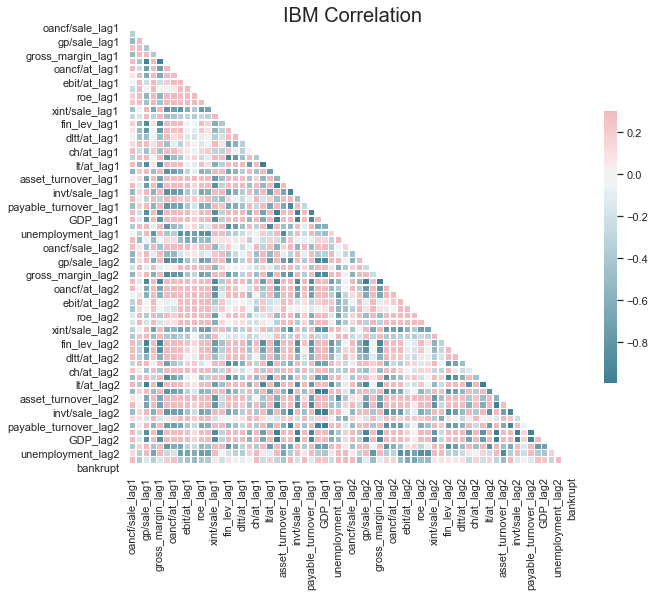

In [250]:
IBM = train[train['LPERMNO'] == 12490]
IBM = IBM.drop(columns=['LPERMNO', 'sic','fyear_lag1','fyear_lag2', 'predict_year', 'bankrupt_year'])
corr = IBM.corr()

sns.set(style="white")
mask = np.triu(np.ones_like(corr, dtype=np.bool))

#f, ax = plt.subplots(figsize=(18, 18))
f, ax = plt.subplots(figsize=(10, 10))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns_plot = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('IBM Correlation', fontsize=20)
#plt.savefig("IBM Correlation.jpg")

In [251]:
high_cor = corr[(abs(corr)>0.9) & (corr!=1)].to_dict()
#IBM_result = high_cor.dropna(how = 'all', axis = 0).dropna(how = 'all', axis = 1)
IBM_result = {}
for key in high_cor:
    res ={}
    for key2 in high_cor[key]:
        if pd.notnull(high_cor[key][key2]) and key[:-4]!= key2[:-4]:
            res[key2] = high_cor[key][key2]
            IBM_result[key] = res
IBM_result

{'oancf/sale_lag1': {'oancf/at_lag1': 0.9045239384024868},
 'gp/sale_lag1': {'oancf/seq_lag1': -0.9545542348958322,
  'gross_margin_lag2': 0.9126913463655268,
  'fin_lev_lag2': -0.9485625366878291,
  'at/lt_lag2': 0.94131768552435,
  'lt/at_lag2': -0.9574935844133617},
 'ros_lag1': {'ebit/at_lag1': 0.9294232580601568,
  'roe_lag1': 0.9543590602110289,
  'roa_lag1': 0.9945843721631307},
 'gross_margin_lag1': {'oancf/seq_lag1': -0.9545542348958322,
  'gp/sale_lag2': 0.9126913463655268,
  'fin_lev_lag2': -0.9485625366878291,
  'at/lt_lag2': 0.94131768552435,
  'lt/at_lag2': -0.9574935844133617},
 'oancf/seq_lag1': {'gp/sale_lag1': -0.9545542348958322,
  'gross_margin_lag1': -0.9545542348958322,
  'fin_lev_lag2': 0.9219232695460563,
  'at/lt_lag2': -0.9197986152120259,
  'lt/at_lag2': 0.936020980046569},
 'oancf/at_lag1': {'oancf/sale_lag1': 0.9045239384024868},
 'ebit/seq_lag1': {'roe_lag1': 0.9331396608834768,
  'asset_turnover_lag1': 0.90430787477219},
 'ebit/at_lag1': {'ros_lag1': 0.92

### Bankrupt company

Text(0.5, 1, 'Winn Dixie Stores Correlation')

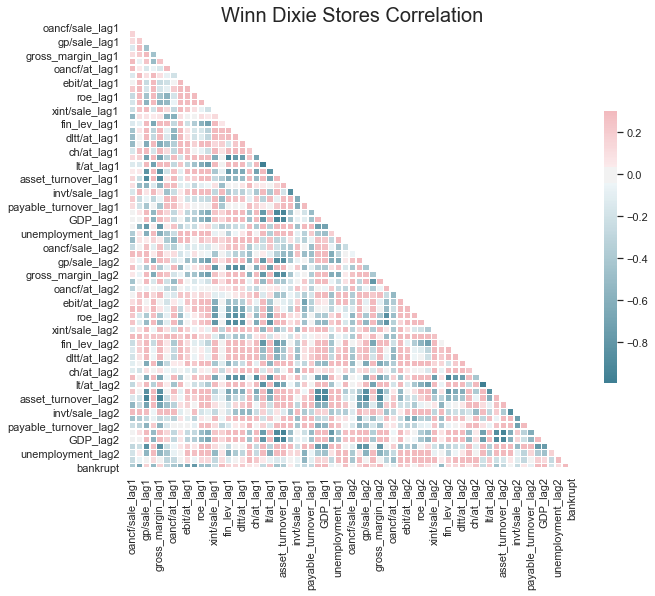

In [252]:
#WINN DIXIE STORES INC
WINN = train[train['LPERMNO'] == 24803]
WINN = WINN.drop(columns=['LPERMNO', 'sic','fyear_lag1','fyear_lag2', 'predict_year', 'bankrupt_year'])
corr2 = WINN.corr()

sns.set(style="white")
mask = np.triu(np.ones_like(corr2, dtype=np.bool))

#f, ax = plt.subplots(figsize=(18, 18))
f, ax = plt.subplots(figsize=(10, 10))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns_plot = sns.heatmap(corr2, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Winn Dixie Stores Correlation', fontsize=20)
#plt.savefig("Winn Dixie Stores Correlation.jpg")

Text(0.5, 1.0, 'Relationship between Features and Bankrupt')

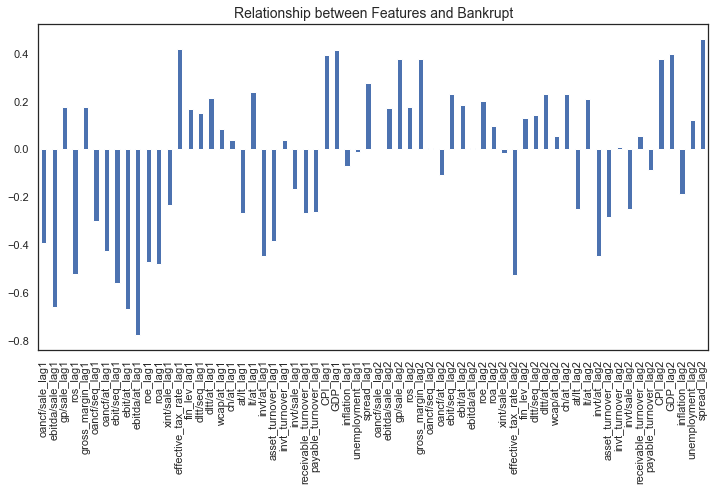

In [253]:
bcorr = WINN.corr()['bankrupt'][:-1]
bcorr.plot(kind = 'bar', figsize = (12,6))
plt.title('Relationship between Features and Bankrupt', fontsize=14)

In [254]:
high_cor2 = corr2[(abs(corr2)>0.9) & (corr2!=1)].to_dict()
#WINN_result = high_cor.dropna(how = 'all', axis = 0).dropna(how = 'all', axis = 1)
WINN_result = {}
for key in high_cor2:
    res ={}
    for key2 in high_cor2[key]:
        if pd.notnull(high_cor2[key][key2]) and key[:-4]!= key2[:-4]:
            res[key2] = high_cor2[key][key2]
            WINN_result[key] = res

In [255]:
both_high_cor = {}
common = set(WINN_result.keys()).intersection(IBM_result.keys())
for key in common:
    res = []
    for key2 in WINN_result[key]:
        if (key2 in IBM_result[key].keys()) and np.sign(WINN_result[key][key2]) == np.sign(IBM_result[key][key2]):
            res.append(key2)
            both_high_cor[key] = res
both_high_cor

{'roe_lag2': ['ros_lag2', 'roa_lag2'],
 'at/lt_lag1': ['fin_lev_lag1', 'lt/at_lag1'],
 'gross_margin_lag2': ['gp/sale_lag1'],
 'oancf/sale_lag1': ['oancf/at_lag1'],
 'roa_lag2': ['ros_lag2', 'roe_lag2'],
 'roa_lag1': ['ros_lag1', 'roe_lag1'],
 'GDP_lag1': ['invt/at_lag1', 'CPI_lag1', 'CPI_lag2'],
 'invt/at_lag2': ['GDP_lag2'],
 'oancf/at_lag2': ['oancf/sale_lag2'],
 'gp/sale_lag1': ['gross_margin_lag2'],
 'gp/sale_lag2': ['gross_margin_lag1'],
 'fin_lev_lag2': ['at/lt_lag2', 'lt/at_lag2'],
 'gross_margin_lag1': ['gp/sale_lag2'],
 'lt/at_lag1': ['fin_lev_lag1', 'at/lt_lag1'],
 'fin_lev_lag1': ['at/lt_lag1', 'lt/at_lag1'],
 'oancf/at_lag1': ['oancf/sale_lag1'],
 'dltt/seq_lag2': ['dltt/at_lag2'],
 'CPI_lag2': ['GDP_lag1', 'GDP_lag2'],
 'ros_lag2': ['roe_lag2', 'roa_lag2'],
 'invt/at_lag1': ['CPI_lag1', 'GDP_lag1', 'GDP_lag2'],
 'roe_lag1': ['ros_lag1', 'roa_lag1'],
 'at/lt_lag2': ['fin_lev_lag2', 'lt/at_lag2'],
 'lt/at_lag2': ['fin_lev_lag2', 'at/lt_lag2'],
 'CPI_lag1': ['invt/at_lag1', 

In [256]:
train.drop(columns = ['roe_lag1', 'roe_lag2','ros_lag1', 'ros_lag2','lt/at_lag1','lt/at_lag2','invt/at_lag1','invt/at_lag2','oancf/at_lag1','oancf/at_lag2','gross_margin_lag1','gross_margin_lag2','CPI_lag1','CPI_lag2'], inplace = True)  
test.drop(columns = ['roe_lag1', 'roe_lag2','ros_lag1', 'ros_lag2','lt/at_lag1','lt/at_lag2','invt/at_lag1','invt/at_lag2','oancf/at_lag1','oancf/at_lag2','gross_margin_lag1','gross_margin_lag2','CPI_lag1','CPI_lag2'], inplace = True)  


# Dummy

In [257]:
dummy_sic_train = pd.get_dummies(train['sic'])
train.drop(columns=['LPERMNO', 'sic','fyear_lag1','fyear_lag2', 'predict_year', 'bankrupt_year'], inplace = True)
train = pd.concat([dummy_sic_train, train], axis=1)

dummy_sic_test = pd.get_dummies(test['sic'])
test.drop(columns=['LPERMNO', 'sic','fyear_lag1','fyear_lag2', 'predict_year', 'bankrupt_year'], inplace = True)
test = pd.concat([dummy_sic_test, test], axis=1)

In [258]:
x_test = test[test.columns[:-1]]
y_test = test['bankrupt']

# Oversampling and Undersampling

In [259]:
# Only supports Continuous Features
def oversampling(data, y_label, k = 5, seed = 1):
    
    from imblearn.over_sampling import SMOTE
    X = data.loc[:, data.columns != y_label]
    y = data[y_label]
    sm = SMOTE(sampling_strategy = 'auto', k_neighbors = k, random_state = seed, n_jobs = -1)
    X_res, y_res = sm.fit_resample(X, y)
    return X_res, y_res

# Supports Categorical and Continuous Features
def oversampling_nc(data, y_label, k = 5, seed = 1, cat_features = [None]):
    
    from imblearn.over_sampling import SMOTENC
    X = data.loc[:, data.columns != y_label]
    y = data[y_label]
    sm = SMOTENC(sampling_strategy = 'auto', k_neighbors = k, random_state = seed, categorical_features = cat_features, n_jobs = -1)
    X_res, y_res = sm.fit_resample(X, y)
    return X_res, y_res


def undersampling(data, y_label, n = 3):

    from imblearn.under_sampling import NearMiss
    X = data.loc[:, data.columns != y_label]
    y = data[y_label]
    nm = NearMiss(sampling_strategy = 'auto', n_jobs = -1)
    X_res, y_res = nm.fit_resample(X, y)
    return X_res, y_res

In [260]:
# oversampling the data
x_train, y_train = oversampling_nc(train, 'bankrupt', cat_features = list(range(0,10)))

# remove the newly syntesized data by half before undersampling
cm1_smote = pd.merge(x_train.sample(frac = 0.5, random_state = 1),
                     y_train.sample(frac = 0.5, random_state = 1), 
                     left_index = True,
                     right_index = True)

x_train, y_train = undersampling(cm1_smote, 'bankrupt')

cm1_nearmiss = pd.merge(x_train, y_train, left_index = True, right_index = True)

cm1_nearmiss['bankrupt'].value_counts()

1.0    30341
0.0    30341
Name: bankrupt, dtype: int64

# Logistic Lasso

In [261]:
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(x_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=42, selection='cyclic',
        tol=0.0001, verbose=False)

In [262]:
lasso.alpha_

0.0019827507592504465

In [263]:
coef = dict(zip(x_train.columns,lasso.coef_))
sorted(coef.items(), key=lambda item: abs(item[1]),reverse=True)

[('GDP_lag2', 0.6052298936439752),
 ('Wholesale Trade', -0.5558750013596583),
 ('ch/at_lag1', -0.4404357357208743),
 ('Mining', -0.43331153060034766),
 ('Services', -0.4294339762374015),
 ('dltt/at_lag2', 0.3115872080632104),
 ('Finance, Insurance and Real Estate', -0.2978026692229959),
 ('roa_lag1', -0.23444921051240267),
 ('Transportation, Communications, Electric, Gas and Sanitary service',
  -0.23035400275393292),
 ('Nonclassifiable', -0.20529170896965132),
 ('Manufacturing', -0.16701025305134393),
 ('spread_lag2', -0.11631761095802834),
 ('Construction', -0.07607071073577779),
 ('Retail Trade', -0.06931150998757413),
 ('ebitda/at_lag2', -0.06286891658099726),
 ('ebitda/at_lag1', -0.05362059515110119),
 ('asset_turnover_lag1', 0.048847556538975934),
 ('at/lt_lag2', -0.012153964177119558),
 ('asset_turnover_lag2', 0.009504397823313991),
 ('effective_tax_rate_lag1', -0.009080977277597416),
 ('dltt/at_lag1', -0.008850548528145074),
 ('at/lt_lag1', -0.006464685267222167),
 ('ebit/seq_l

In [264]:
x_train.drop(columns=['ebit/at_lag1', 'ebit/at_lag2','inflation_lag1','inflation_lag2','unemployment_lag1','unemployment_lag2'], inplace = True)
x_test.drop(columns=['ebit/at_lag1', 'ebit/at_lag2','inflation_lag1','inflation_lag2','unemployment_lag1','unemployment_lag2'], inplace = True)


# Baseline Model - Logistic Regression

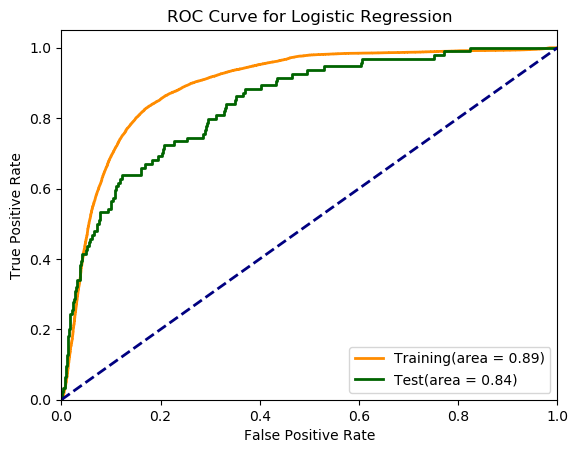


		Logistic Regression

               precision    recall  f1-score   support

         0.0    0.86349   0.76701   0.81240     30341
         1.0    0.79043   0.87874   0.83225     30341

    accuracy                        0.82288     60682
   macro avg    0.82696   0.82288   0.82233     60682
weighted avg    0.82696   0.82288   0.82233     60682



In [387]:
lr = LogisticRegression(n_jobs = -1)
lr.fit(x_train, y_train)

y_pred = lr.predict_proba(x_train)
fpr,tpr,threshold = roc_curve(y_train, y_pred[:,1])
roc_auc = auc(fpr,tpr)

y_pred2 = lr.predict_proba(x_test)
fpr2,tpr2,threshold2 = roc_curve(y_test, y_pred2[:,1])
roc_auc2 = auc(fpr2,tpr2)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Training(area = %0.2f)' % roc_auc)
plt.plot(fpr2, tpr2, color='darkgreen',
         lw=lw, label='Test(area = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.show()

y_pred_binary = [1 if i >= 0.5 else 0 for i in y_pred[:,1]]

print('\n\033[1m'+'\t\tLogistic Regression\n\n'+'\033[0m', classification_report(y_train, y_pred_binary, digits=5))

In [349]:
confusion_matrix(y_train, y_pred_binary)

array([[23272,  7069],
       [ 3679, 26662]])

# Cross Validation

## Weighted Logistic Regression

In [267]:
wlr = LogisticRegression(n_jobs = -1)

class_weight = [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:0.1,1:1}, {0:1,1:10}, {0:1,1:100}]
hyperparameters = dict(class_weight = class_weight)

clf = GridSearchCV(wlr, hyperparameters, scoring = 'roc_auc', cv=5, verbose=2, n_jobs =-1)
clf.fit(x_train, y_train)
best_model_wlr = clf.best_estimator_
clf.best_params_, clf.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.8s finished


({'class_weight': {0: 1, 1: 1}}, 0.8518348817415585)

Best Weight is 1:1 which is the same as normal logistics regression

## XG Boost

In [274]:
xg = xgb.XGBClassifier()
estimators=[10,50,100,300]
depths=[4,8,10,20] 
hyperparameters = dict(n_estimators=estimators, max_depth=depths)
clf = GridSearchCV(xg, hyperparameters, scoring = 'roc_auc', cv=5, n_jobs=-1, verbose=3)
clf.fit(x_train, y_train)
best_xg_boost = clf.best_estimator_

clf.best_params_, clf.best_score_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 19.4min finished


({'max_depth': 8, 'n_estimators': 300}, 0.9970902026315585)

In [282]:
best_xg_boost.fit(x_train, y_train)
y_pred = best_xg_boost.predict_proba(x_train)

In [283]:
precision, recall, thresholds = precision_recall_curve(y_train, y_pred[:,1])
f1 = 2*(precision*recall)/(precision+recall)
best_f1 = max(f1)
best_threshold = thresholds[np.where(f1 == max(f1))]
print(f'Best F1 is {best_f1} at threshold = {best_threshold}')
y_pred_binary = [1 if i >= best_threshold else 0 for i in y_pred[:,1]]
print('\n\033[1m'+'\t\t XG Boost\n\n'+'\033[0m', classification_report(y_train, y_pred_binary, digits=5))

Best F1 is 1.0 at threshold = [0.9284267]

		 XG Boost

               precision    recall  f1-score   support

         0.0    1.00000   1.00000   1.00000     30341
         1.0    1.00000   1.00000   1.00000     30341

    accuracy                        1.00000     60682
   macro avg    1.00000   1.00000   1.00000     60682
weighted avg    1.00000   1.00000   1.00000     60682



In [284]:
confusion_matrix(y_train, y_pred_binary)

array([[30341,     0],
       [    0, 30341]])

In [285]:
fpr_xg,tpr_xg,threshold_xg = roc_curve(y_train, y_pred[:,1])
roc_auc_xg = auc(fpr_xg,tpr_xg)

Text(0.5, 1.0, 'Feature Importance of XGBoost')

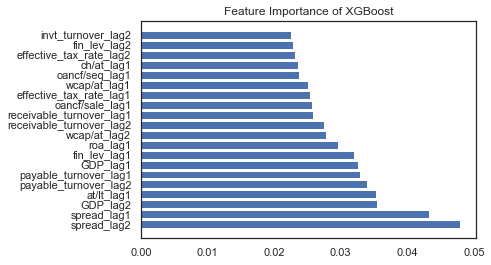

In [286]:
feature_imp = sorted(list(zip(best_xg_boost.feature_importances_, x_train.columns)), key = lambda x: x[0], reverse = True)
feature_imp

top_x = 20

imp = [i[0] for i in feature_imp][:top_x]
fea = [i[1] for i in feature_imp][:top_x]

plt.barh(fea, imp)
plt.title('Feature Importance of XGBoost')

## Random Forset

In [280]:
rf = RandomForestClassifier(n_jobs = -1)
estimators=[10,50,100,500]
depths=[4,8,10,20] 
hyperparameters = dict(n_estimators=estimators, max_depth=depths)
clf = GridSearchCV(rf, hyperparameters, scoring = 'roc_auc', cv=5, n_jobs=-1, verbose=3)
clf.fit(x_train, y_train)
best_rf = clf.best_estimator_

clf.best_params_, clf.best_score_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 10.0min finished


({'max_depth': 20, 'n_estimators': 100}, 0.9854729651882866)

In [291]:
best_rf.fit(x_train, y_train)
y_pred = best_rf.predict_proba(x_train)

In [294]:
precision, recall, thresholds = precision_recall_curve(y_train, y_pred[:,1])
f1 = 2*(precision*recall)/(precision+recall)
best_f1 = max(f1)
best_threshold = thresholds[np.where(f1 == max(f1))]
print(f'Best F1 is {best_f1} at threshold = {best_threshold}')
y_pred_binary = [1 if i >= best_threshold else 0 for i in y_pred[:,1]]
print('\n\033[1m'+'\t\t Random Forest\n\n'+'\033[0m', classification_report(y_train, y_pred_binary, digits=5))

Best F1 is 0.9992255087748207 at threshold = [0.84654248]

		 Random Forest

               precision    recall  f1-score   support

         0.0    0.99927   0.99918   0.99923     30341
         1.0    0.99918   0.99927   0.99923     30341

    accuracy                        0.99923     60682
   macro avg    0.99923   0.99923   0.99923     60682
weighted avg    0.99923   0.99923   0.99923     60682



In [298]:
confusion_matrix(y_train, y_pred_binary)

array([[30316,    25],
       [   22, 30319]])

In [295]:
fpr_rf,tpr_rf,threshold_rf = roc_curve(y_train, y_pred[:,1])
roc_auc_rf = auc(fpr_rf,tpr_rf)

Text(0.5, 1.0, 'Feature Importance of Random Forest')

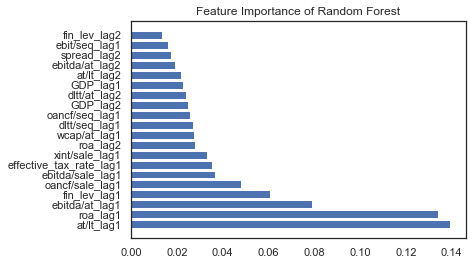

In [297]:
feature_imp = sorted(list(zip(best_rf.feature_importances_, x_train.columns)), key = lambda x: x[0], reverse = True)
feature_imp

top_x = 20

imp = [i[0] for i in feature_imp][:top_x]
fea = [i[1] for i in feature_imp][:top_x]

plt.barh(fea, imp)
plt.title('Feature Importance of Random Forest')

## Neural Network

In [300]:
dnn = MLPClassifier()

hidden_layer_sizes = [(50,50,50), (50,100,50), (100,)]
hyperparameters = dict(hidden_layer_sizes=hidden_layer_sizes)
clf = GridSearchCV(dnn, hyperparameters, scoring = 'roc_auc', cv=5, n_jobs=-1, verbose=3)
clf.fit(x_train, y_train)
best_dnn = clf.best_estimator_

clf.best_params_, clf.best_score_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:  1.4min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  2.7min remaining:   41.2s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.9min finished


({'hidden_layer_sizes': (50, 100, 50)}, 0.9510067250862578)

In [325]:
best_dnn.fit(x_train, y_train)
y_pred = best_dnn.predict_proba(x_train)

In [326]:
precision, recall, thresholds = precision_recall_curve(y_train, y_pred[:,1])
f1 = 2*(precision*recall)/(precision+recall)
best_f1 = max(f1)
best_threshold = thresholds[np.where(f1 == max(f1))]
print(f'Best F1 is {best_f1} at threshold = {best_threshold}')
y_pred_binary = [1 if i >= best_threshold else 0 for i in y_pred[:,1]]
print('\n\033[1m'+'\t\t Neural Network \n\n'+'\033[0m', classification_report(y_train, y_pred_binary, digits=5))

Best F1 is 0.9993740115972588 at threshold = [0.47906332]

		 Neural Network 

               precision    recall  f1-score   support

         0.0    0.99974   0.99901   0.99937     30341
         1.0    0.99901   0.99974   0.99937     30341

    accuracy                        0.99937     60682
   macro avg    0.99937   0.99937   0.99937     60682
weighted avg    0.99937   0.99937   0.99937     60682



In [327]:
confusion_matrix(y_train, y_pred_binary)

array([[30311,    30],
       [    8, 30333]])

In [328]:
fpr_dnn,tpr_dnn,threshold_dnn = roc_curve(y_train, y_pred[:,1])
roc_auc_dnn = auc(fpr_dnn,tpr_dnn)

# SVM

In [396]:
lsvm = svm.LinearSVC()
C=[1, 10, 100, 1000]
hyperparameters = dict(C=C)
clf = GridSearchCV(lsvm, hyperparameters, scoring = 'roc_auc', cv=5, n_jobs=-1, verbose=3)
clf.fit(x_train, y_train)
best_lsvm = clf.best_estimator_

clf.best_params_, clf.best_score_

In [382]:
best_lsvm.fit(x_train, y_train)
y_pred = best_lsvm.predict(x_train)

In [383]:
precision, recall, thresholds = precision_recall_curve(y_train, y_pred)
f1 = 2*(precision*recall)/(precision+recall)
best_f1 = max(f1)
best_threshold = thresholds[np.where(f1 == max(f1))]
print(f'Best F1 is {best_f1} at threshold = {best_threshold}')
print('\n\033[1m'+'\t\t Linear SVM \n\n'+'\033[0m', classification_report(y_train, y_pred, digits=5))

Best F1 is 0.6666666666666666 at threshold = [0.]

		 Linear SVM 

               precision    recall  f1-score   support

         0.0    0.63304   0.97874   0.76882     30341
         1.0    0.95317   0.43265   0.59515     30341

    accuracy                        0.70570     60682
   macro avg    0.79310   0.70570   0.68199     60682
weighted avg    0.79310   0.70570   0.68199     60682



In [384]:
confusion_matrix(y_train, y_pred_binary)

array([[23272,  7069],
       [ 3679, 26662]])

In [385]:
fpr_lsvm,tpr_lsvm,threshold_lsvm = roc_curve(y_train, y_pred)
roc_auc_lsvm = auc(fpr_lsvm,tpr_lsvm)

# Non_Linear SVM

## ROC Curve Comparsion Between Models on Training Set

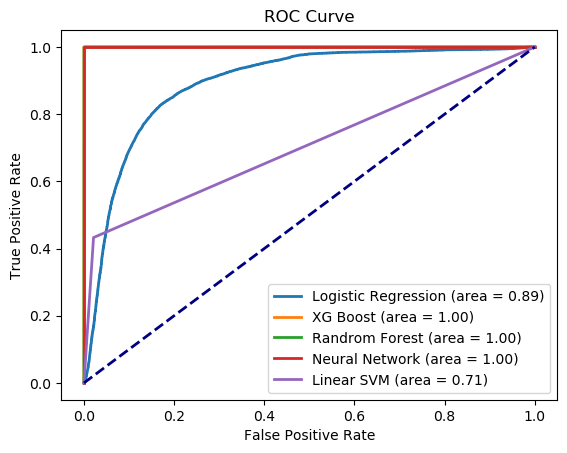

In [388]:
plt.figure(0).clf()

plt.plot(fpr, tpr, lw=lw, label='Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot(fpr_xg, tpr_xg, lw=lw, label='XG Boost (area = %0.2f)' % roc_auc_xg)
plt.plot(fpr_rf, tpr_rf, lw=lw, label='Randrom Forest (area = %0.2f)' % roc_auc_rf)
plt.plot(fpr_dnn, tpr_dnn, lw=lw, label='Neural Network (area = %0.2f)' % roc_auc_dnn)
plt.plot(fpr_lsvm, tpr_lsvm, lw=lw, label='Linear SVM (area = %0.2f)' % roc_auc_lsvm)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Best Model

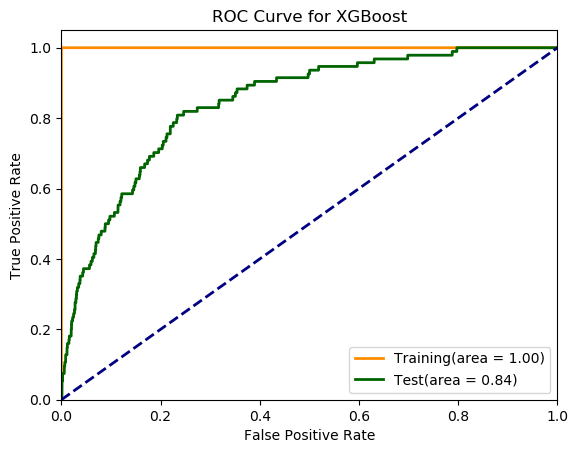

In [352]:
import matplotlib
matplotlib.rc_file_defaults()
best_xg_boost.fit(x_train, y_train)

y_pred = best_xg_boost.predict_proba(x_train)
fpr,tpr,threshold = roc_curve(y_train, y_pred[:,1])
roc_auc = auc(fpr,tpr)

y_pred2 = best_xg_boost.predict_proba(x_test)
fpr2,tpr2,threshold2 = roc_curve(y_test, y_pred2[:,1])
roc_auc2 = auc(fpr2,tpr2)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Training(area = %0.2f)' % roc_auc)
plt.plot(fpr2, tpr2, color='darkgreen',
         lw=lw, label='Test(area = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost')
plt.legend(loc="lower right")
plt.show()


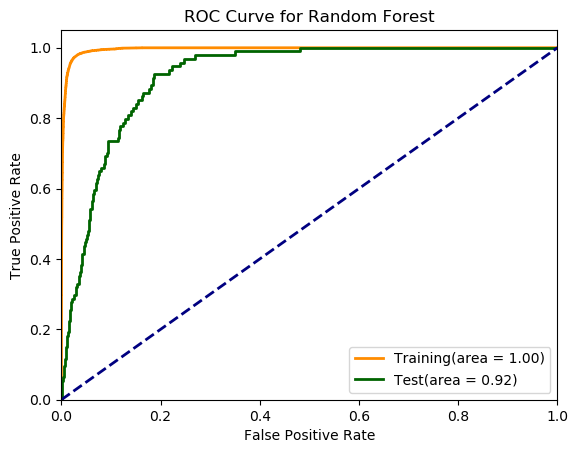

In [377]:
import matplotlib
matplotlib.rc_file_defaults()
best_rf.fit(x_train, y_train)

y_pred = best_rf.predict_proba(x_train)
fpr,tpr,threshold = roc_curve(y_train, y_pred[:,1])
roc_auc = auc(fpr,tpr)

y_pred2 = best_rf.predict_proba(x_test)
fpr2,tpr2,threshold2 = roc_curve(y_test, y_pred2[:,1])
roc_auc2 = auc(fpr2,tpr2)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Training(area = %0.2f)' % roc_auc)
plt.plot(fpr2, tpr2, color='darkgreen',
         lw=lw, label='Test(area = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.legend(loc="lower right")
plt.show()

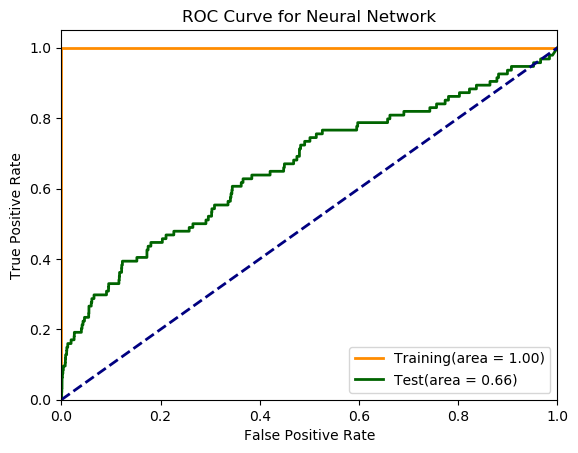

In [378]:
import matplotlib
matplotlib.rc_file_defaults()
best_dnn.fit(x_train, y_train)

y_pred = best_dnn.predict_proba(x_train)
fpr,tpr,threshold = roc_curve(y_train, y_pred[:,1])
roc_auc = auc(fpr,tpr)

y_pred2 = best_dnn.predict_proba(x_test)
fpr2,tpr2,threshold2 = roc_curve(y_test, y_pred2[:,1])
roc_auc2 = auc(fpr2,tpr2)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Training(area = %0.2f)' % roc_auc)
plt.plot(fpr2, tpr2, color='darkgreen',
         lw=lw, label='Test(area = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Neural Network')
plt.legend(loc="lower right")
plt.show()

# Exploratory Data Analysis 

In [361]:
train2 = cm[cm['fyear']<=2005]

# industry distribution

In [363]:
industry_group = train2[['sic','LPERMNO']].drop_duplicates(subset=None, keep='first', inplace=False)
industry_group.groupby('sic').size()

sic
Agriculture, Forestry and Fishing                                       48
Construction                                                           100
Finance, Insurance and Real Estate                                     243
Manufacturing                                                         5007
Mining                                                                 465
Nonclassifiable                                                        142
Retail Trade                                                           844
Services                                                              1564
Transportation, Communications, Electric, Gas and Sanitary service     908
Wholesale Trade                                                        519
dtype: int64

Text(0, 0.5, 'Industry')

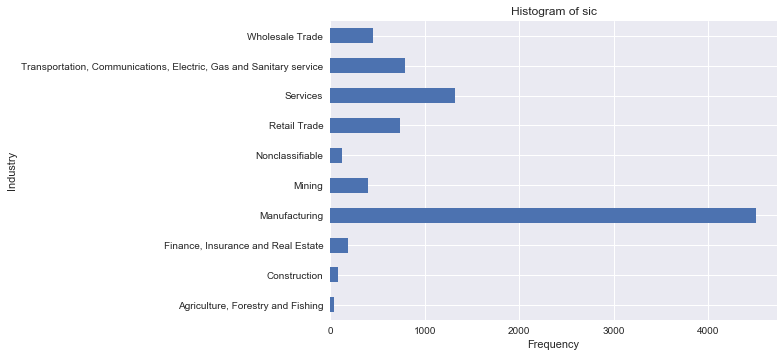

In [364]:
industry_group = cm_distribution[['sic','LPERMNO']].drop_duplicates(subset=None, keep='first', inplace=False).groupby('sic')
industry_group.size().plot(kind='barh')
plt.title('Histogram of sic')
plt.xlabel('Frequency')
plt.ylabel('Industry')

# financial ratios distribution

In [369]:
fr = list(train2)[3:]
len(fr)

34

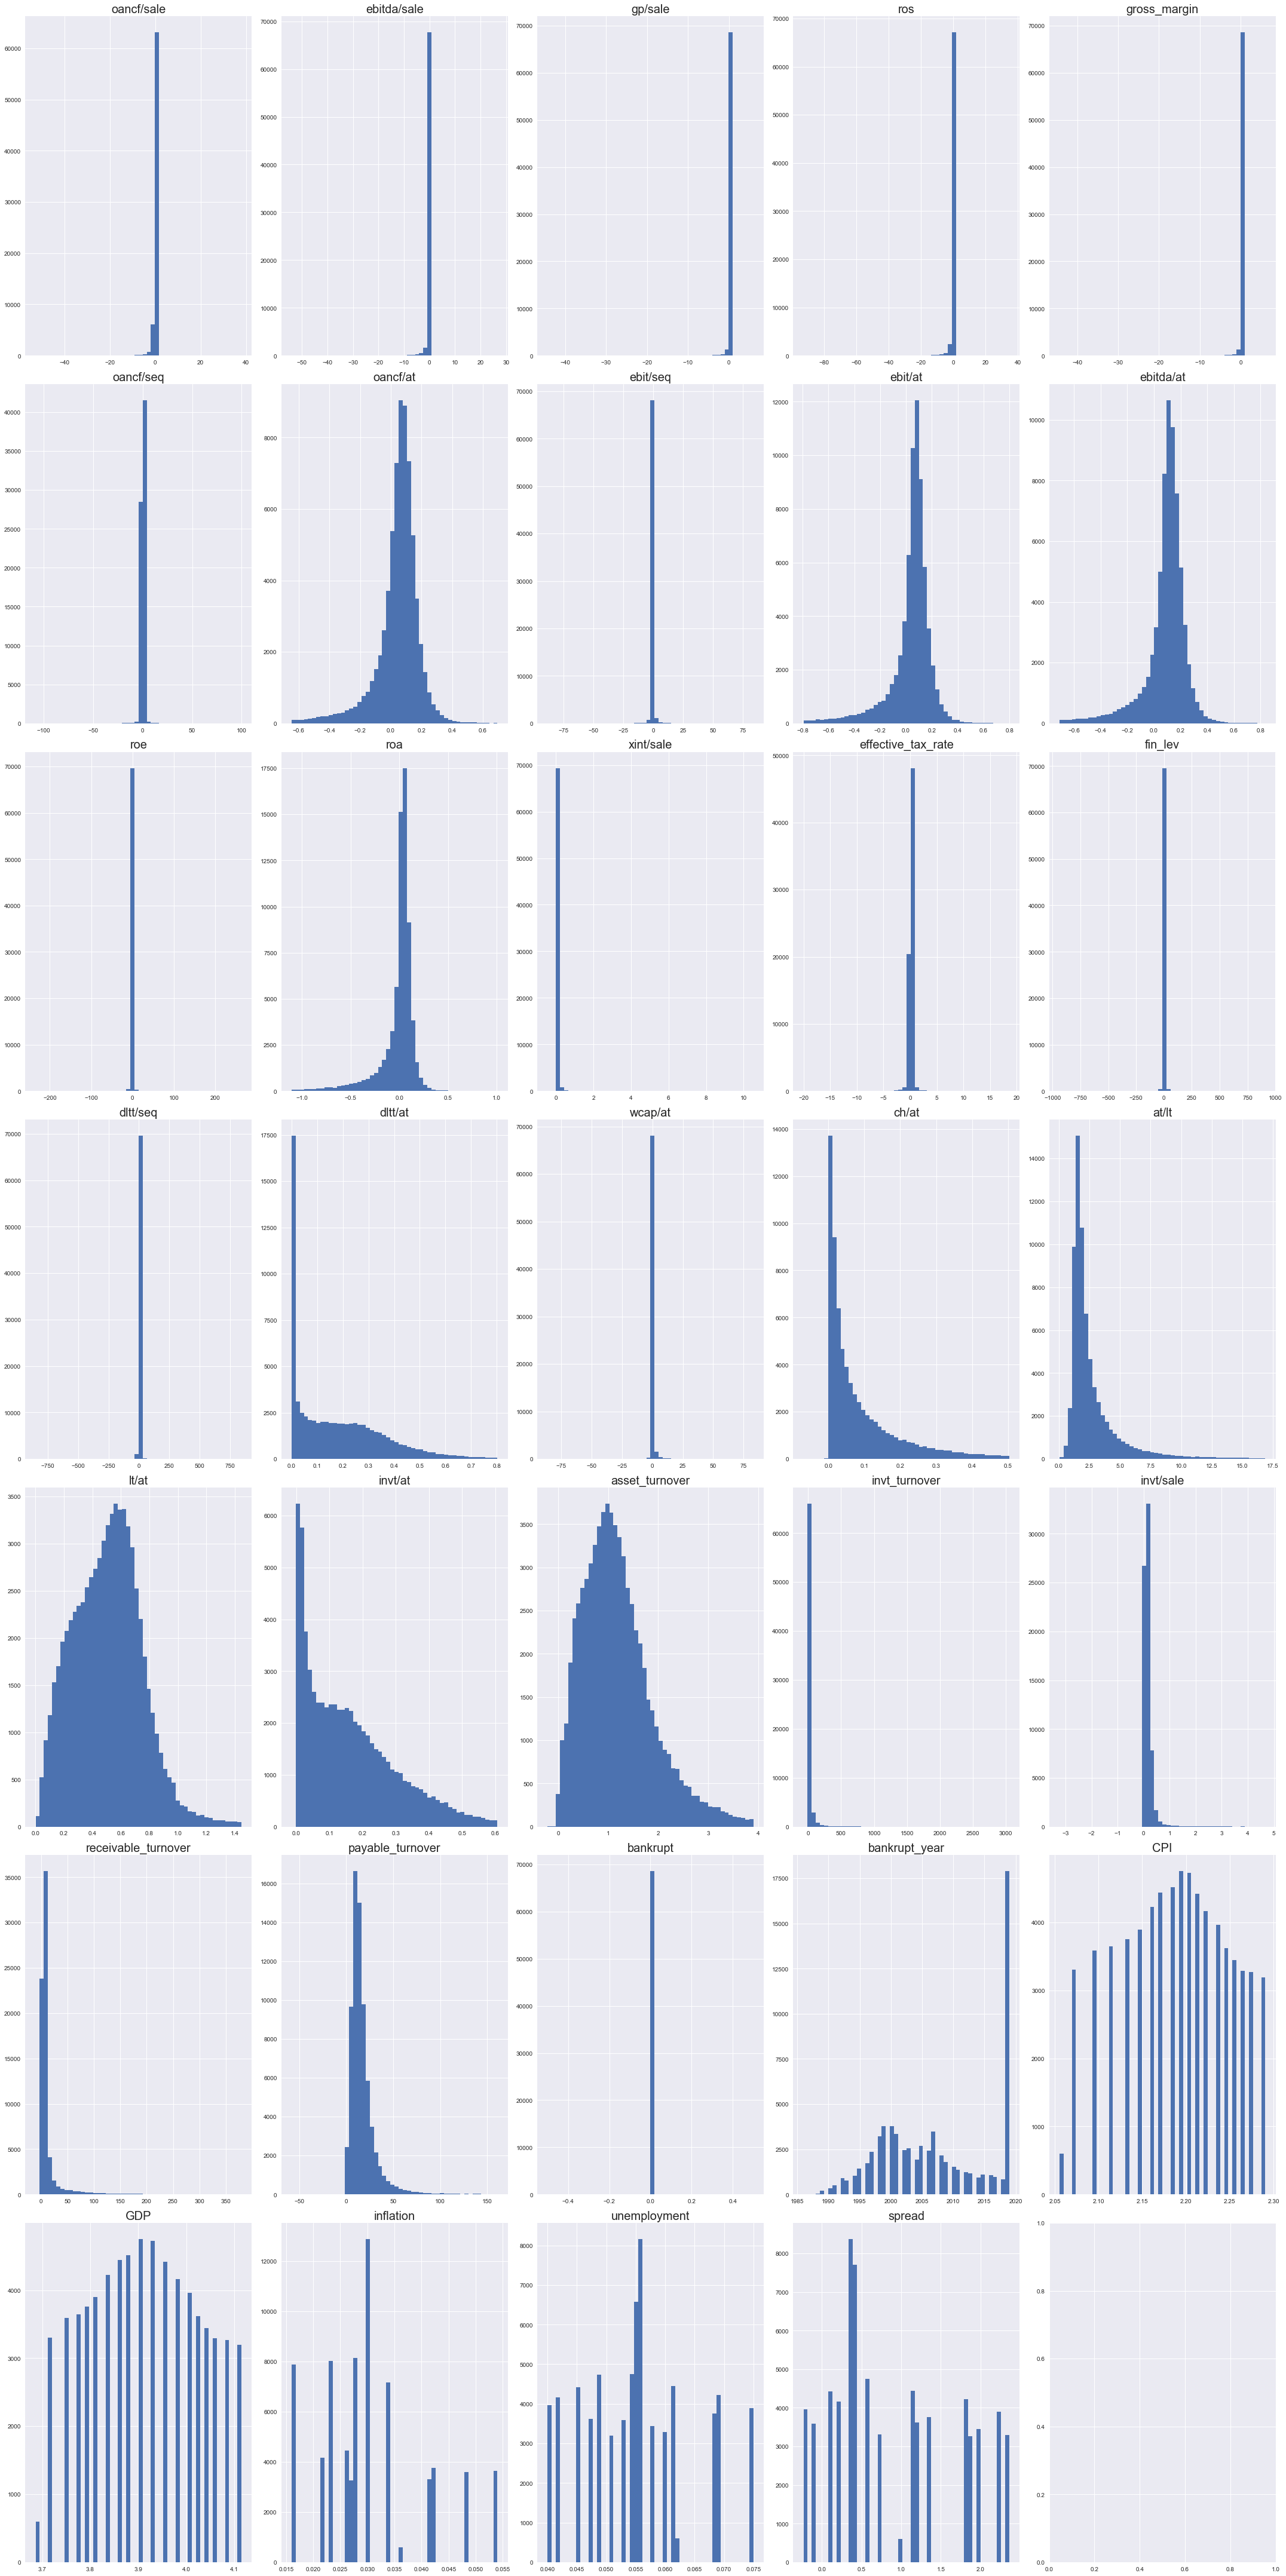

In [375]:
COL_NUM = 5
ROW_NUM = 7
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(30,60))

for i, ratios in enumerate(fr): 
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    df = train2[abs(train2[ratios]-train2[ratios].mean())<3*train2[ratios].std()]
    df[ratios].hist(bins=50,ax=ax)
    ax.set_title(ratios, fontsize=20)
plt.savefig("Distrubution of Financial Ratios.jpg")
plt.tight_layout()

No handles with labels found to put in legend.


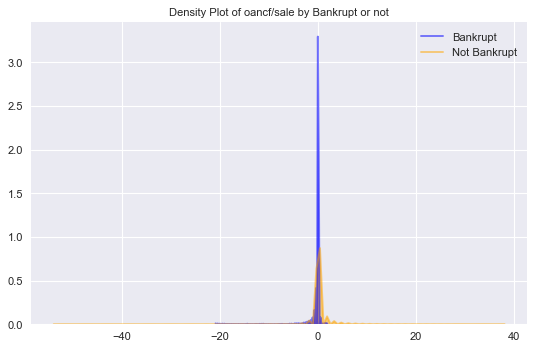

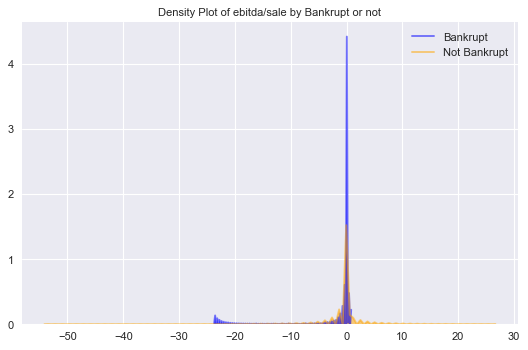

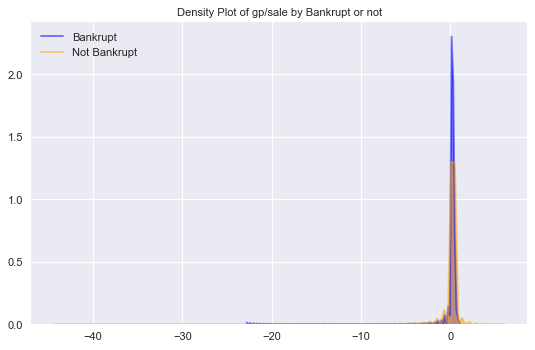

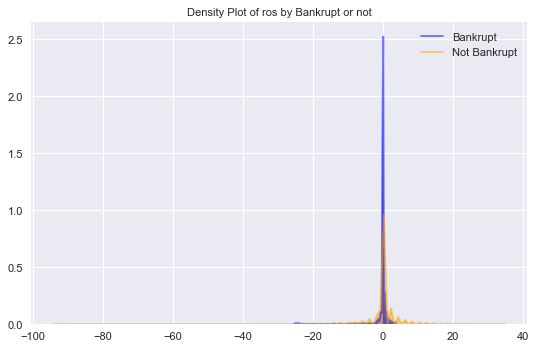

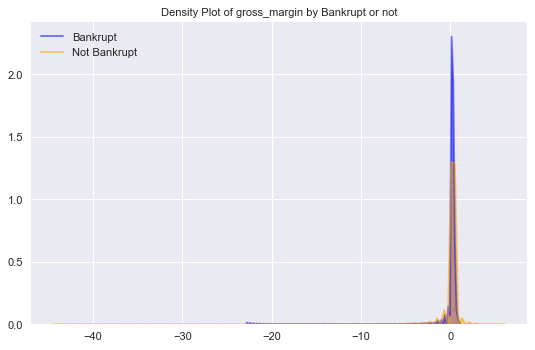

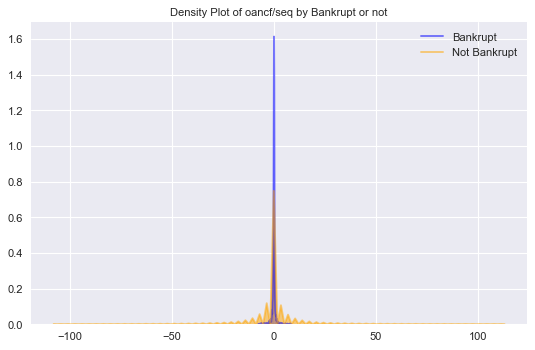

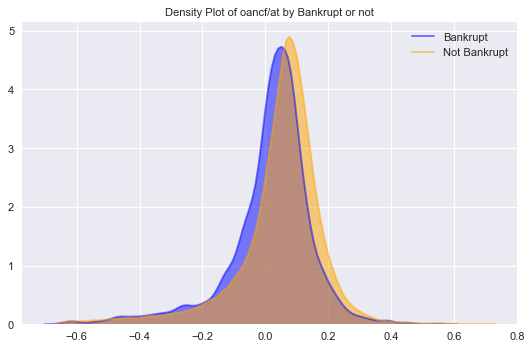

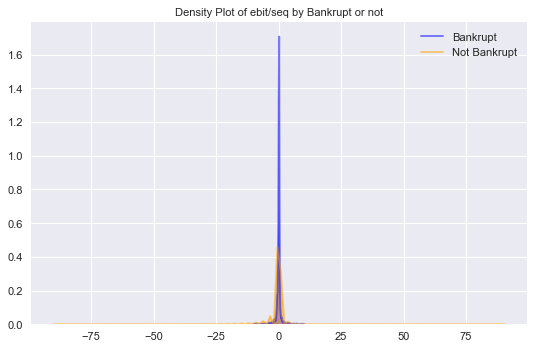

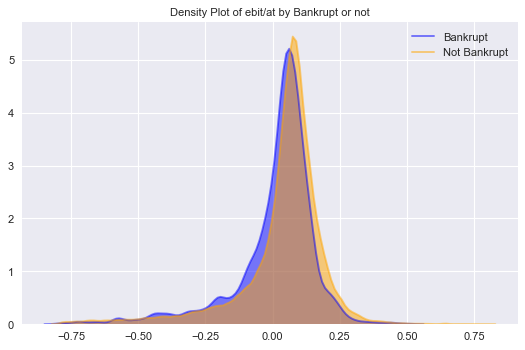

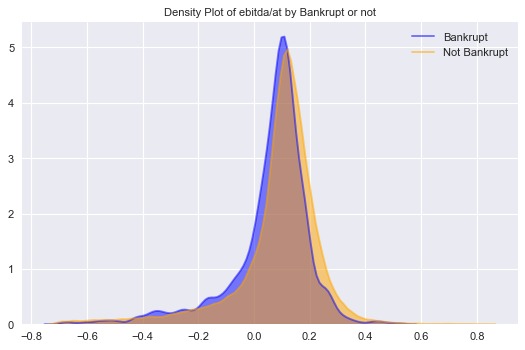

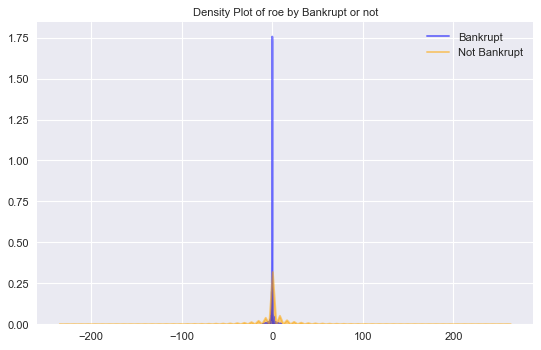

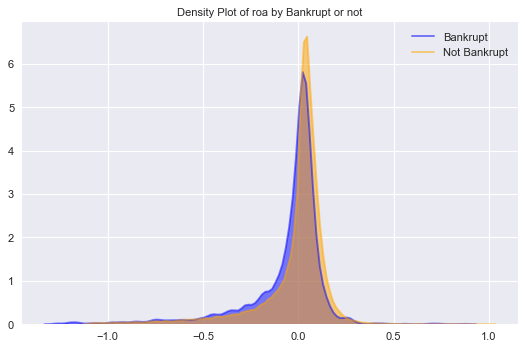

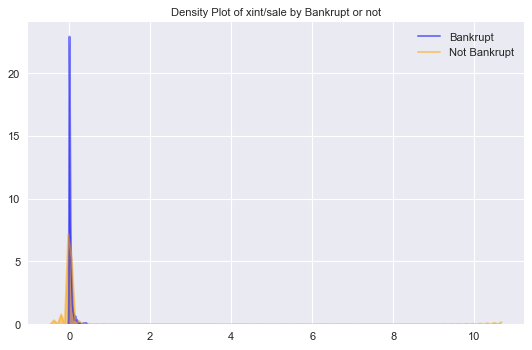

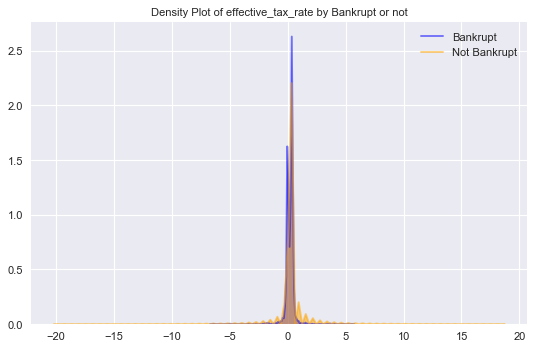

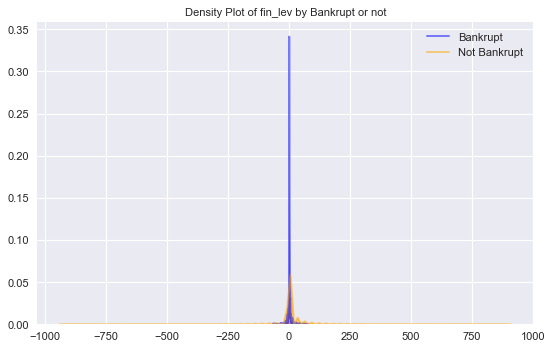

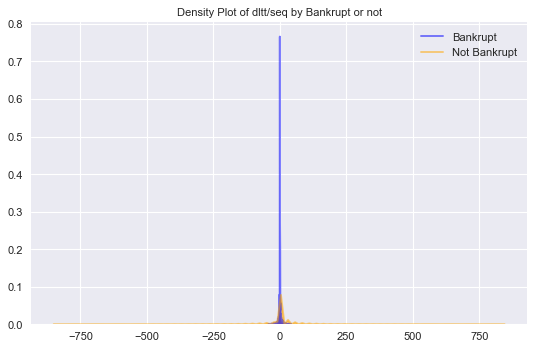

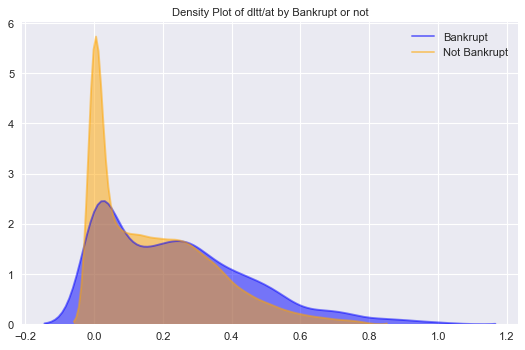

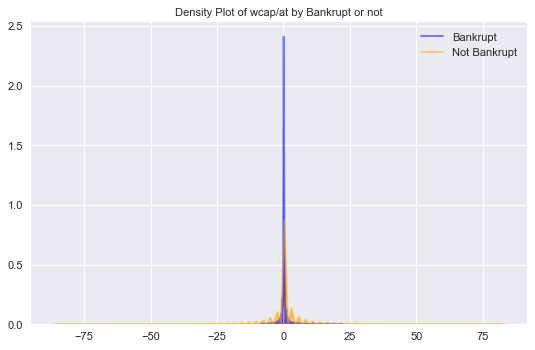

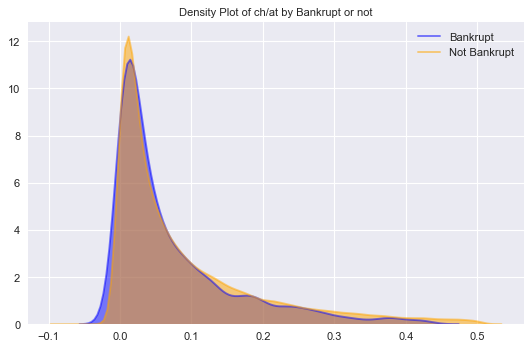

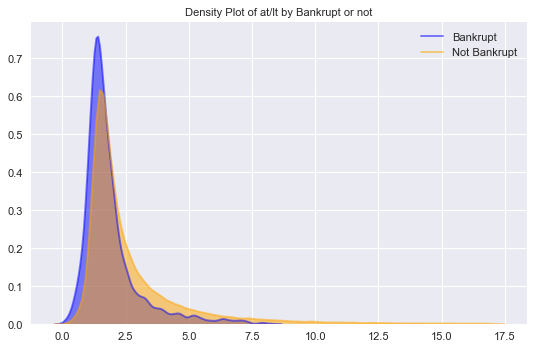

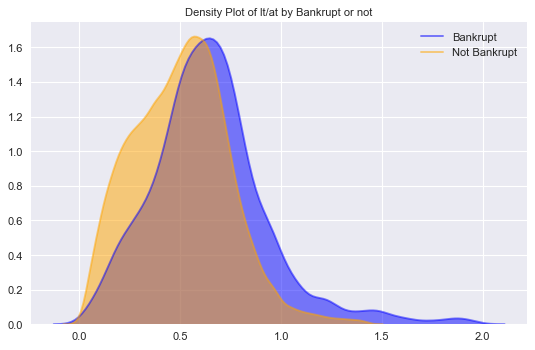

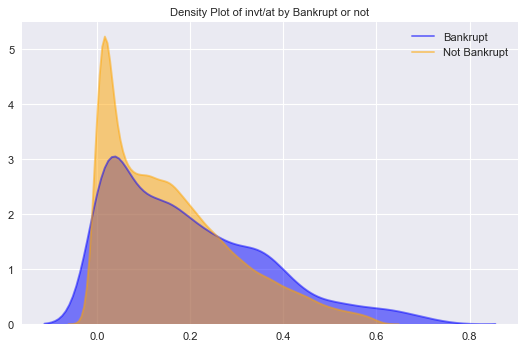

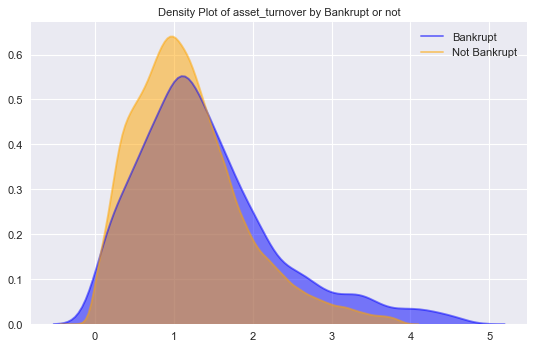

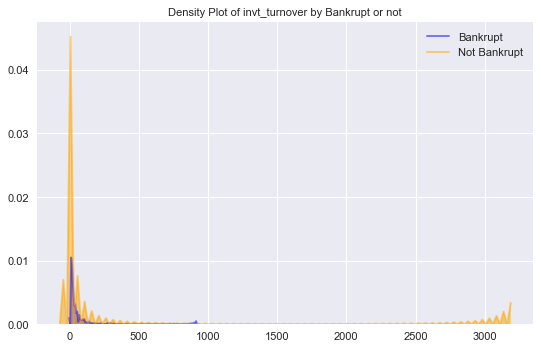

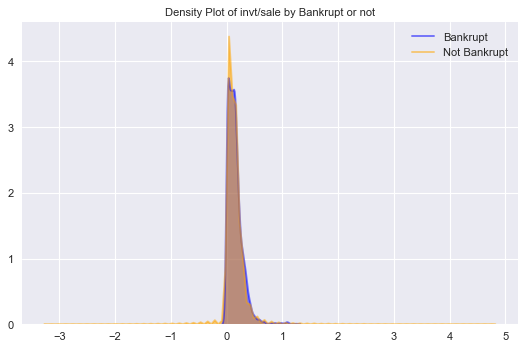

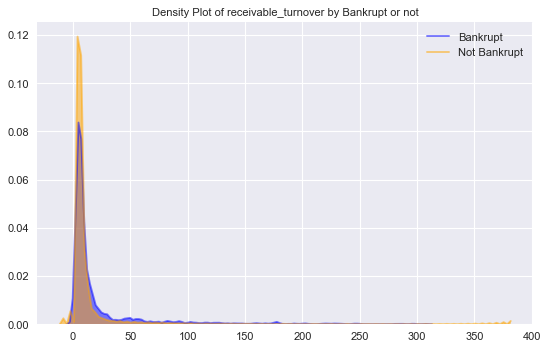

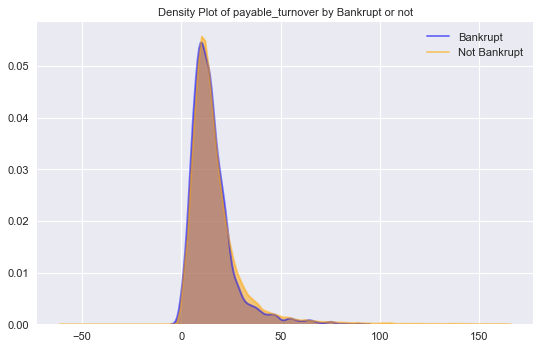

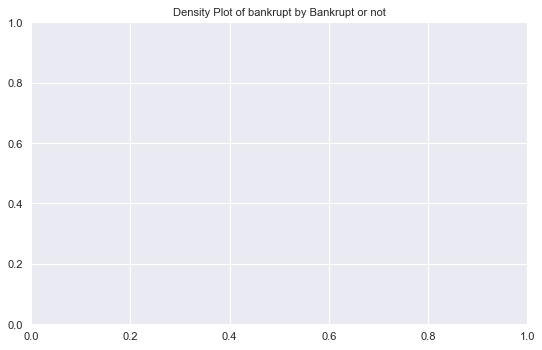

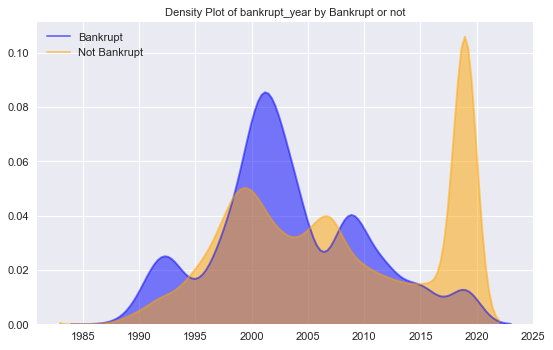

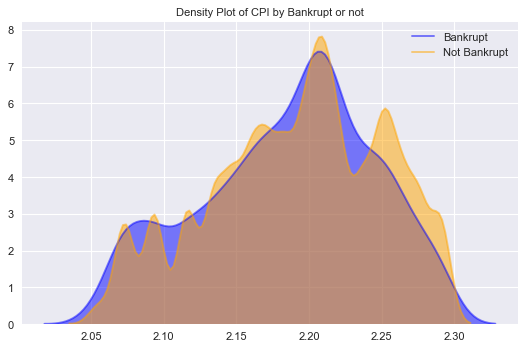

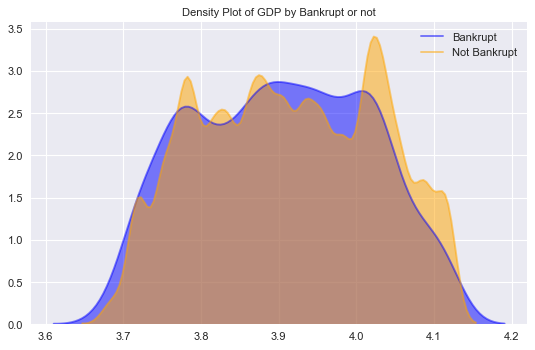

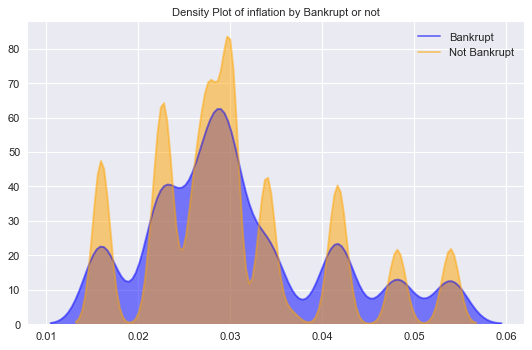

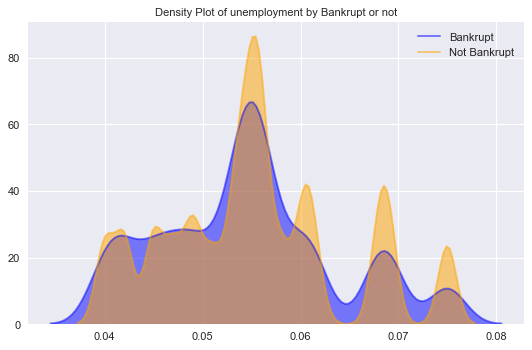

In [376]:
bankrupt = train2[train2['bankrupt']==1]
not_bankrupt = train2[train2['bankrupt']==0]
for i, ratios in enumerate(fr[:-1]):
    plt.figure(figsize=(8,5), dpi= 80)
    bankrupt_df = bankrupt[abs(bankrupt[ratios]-bankrupt[ratios].mean())<3*bankrupt[ratios].std()]
    not_bankrupt_df = not_bankrupt[abs(not_bankrupt[ratios]-not_bankrupt[ratios].mean())<3*not_bankrupt[ratios].std()]
    sns.kdeplot(bankrupt_df[ratios], shade=True, color="blue", label="Bankrupt", alpha=.5)
    sns.kdeplot(not_bankrupt_df[ratios], shade=True, color="orange", label="Not Bankrupt", alpha=.5)
    plt.title('Density Plot of '+ f'{ratios}'+ ' by Bankrupt or not', fontsize=10)
    plt.legend()